In [209]:
from methods import *
from matplotlib.patches import Circle, Wedge, Rectangle, Arc
from matplotlib.collections import PatchCollection
import seaborn as sns
from matplotlib.colors import ListedColormap

In [211]:
def get_isotropic_circle_subplot(ax, N = 20, zorder = 2, add_cbar = False, lambda_obj = None, add_boundary = True, boundary_lw = 1,
                          xlim = None, ylim = None,cbar_ticks = [0.5,1,1.5], fontsize = 10, cbar_name = r"$\lambda$",cmap = matplotlib.cm.RdBu_r, vmin = 0.5, vmax = 1.5,
                         ):
    #source : https://matplotlib.org/stable/gallery/shapes_and_collections/patch_collection.html#sphx-glr-gallery-shapes-and-collections-patch-collection-py
    #source : https://matplotlib.org/stable/gallery/shapes_and_collections/artist_reference.html#sphx-glr-gallery-shapes-and-collections-artist-reference-py
    #to control z order 
    #https://matplotlib.org/stable/tutorials/colors/colors.html#sphx-glr-tutorials-colors-colors-py
    #add each patch separately to ax and mention its zorder

    patches = []

    R = 1
    w = R/N

    center = (0,0)

    poly_obj = lambda_obj
    radii = [(N-i)*w for i in range(N)]#[(i+1)*w for i in range(N)]
    patches = [Wedge((center), radius, 0, 360) for radius in radii] #add width = w in Wedge if you want an annulus
    colors = [poly_obj(radius) for radius in radii]

    ###########
    #colors = 100*np.random.random(len(patches))
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    p = PatchCollection(patches, cmap=cmap, norm = norm, alpha=1, edgecolor = None, zorder = zorder) #bwr #coolwarm #PuOr
    p.set_array(colors)
    ax.add_collection(p)
    if xlim is None:
        xlim = (-1.1*(R), 1.1*(R))
    ax.set_xlim(xlim)
    if ylim is None:
        ylim = (-1.1*(R), 1.1*(R))
    ax.set_ylim(ylim)
    ax.set_aspect("equal")
    ax.axis('off')
    if add_cbar: 
        cbar = plt.colorbar(p, ax = ax, ticks = cbar_ticks)
        cbar.ax.set_yticklabels(labels = [str(x_) for x_ in cbar_ticks], fontsize = fontsize)  # vertically oriented colorbar
        cbar.ax.set_ylabel(cbar_name, rotation=0, fontsize = fontsize)

    ###########
    
    if add_boundary:
        p = Arc(center, 2,2, theta1=0, theta2=360, linewidth=boundary_lw, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        
    return(ax)

In [212]:
def get_quiver_specs(R = 1, theta = 0, roi = "outDV", center = (0,0), stage_init ="wL3", stage_final = "4hAPF", lambda_name ="lambda_isotropic_coeffs", fit_lambdas_df = None,
                     lambda_obj = None,
                    ):
    
    #from roi, get the location
    if roi == "outDV":
        x,y = R*np.cos(theta)+center[0], R*np.sin(theta)+center[1]
    if roi == "DV":
        x,y = R,theta
    
    #from roi get the correct lambda fit poynomial
    if lambda_obj is None:
        query_str = 'stage_init == "' + stage_init + '" and stage_final == "' + stage_final + '" and roi == "' + roi + '" and prop == "'+lambda_name+'"'
        poly_obj = np.poly1d(fit_lambdas_df.query(query_str)["value"].iloc[0])
    else:
        poly_obj = lambda_obj
    #from the polynomial get the value
    lambda_val = poly_obj(np.abs(R))
    #from the value get the direction
    if roi == "outDV" and lambda_val < 1 :
        u = -np.abs(1 - lambda_val)*np.sin(theta)
        v = np.abs(1 - lambda_val)*np.cos(theta)
    if roi == "outDV" and lambda_val >= 1 :
        u = np.abs(1 - lambda_val)*np.cos(theta)
        v = np.abs(1 - lambda_val)*np.sin(theta)
    if roi == "DV" and lambda_val < 1 :
        u = 0
        v = np.abs(1 - lambda_val)
    if roi == "DV" and lambda_val >= 1 :
        u = np.abs(1 - lambda_val)
        v = 0
    
    return(x,y,u,v)

In [213]:
def get_nematic_circle_subplot(ax, stage_init="wL3", stage_final = "4hAPF", lambda_name ="lambda_anisotropic_coeffs", DV_width = 0.2, zorder = 10, fit_lambdas_df = None, add_boundary = True,
                        quiver_scale = 5, quiver_width = 0.005, boundary_lw = 1,
                        xlim = None, ylim = None, lambda_obj = None, roi = "outDV", dtheta = 0, thetas = None, n_theta = 10, scatter_s = 1,
                        Rs = [0.1, 0.3, 0.5, 0.7, 0.9],
                       ):
    #https://stackoverflow.com/questions/34375345/how-does-pythons-matplotlib-pyplot-quiver-exactly-work
    #dtheta = 0.1
    #Rs= np.linspace(0.1,0.9, 5)#1
    if thetas is None: thetas = np.linspace(0+dtheta, 2*np.pi-dtheta,n_theta)
    #center_bottom = (0,-DV_width/2)
    #center_top = (0,DV_width/2)
    center = (0,0)

    x = []
    y = []
    u = []
    v = []
    
    if roi == "outDV":
        for R in Rs:
            for theta in thetas:
                x_,y_,u_,v_ = get_quiver_specs(R=R, theta=theta, roi=roi, center=center, stage_init=stage_init, stage_final=stage_final, lambda_name=lambda_name, fit_lambdas_df = fit_lambdas_df,
                                               lambda_obj = lambda_obj
                                              )
                x += [x_]
                y += [y_]
                u += [u_]
                v += [v_]

    #DV
    x_DVs = np.linspace(-1,1, 10)
    y_DVs = np.linspace(-1,1, 10)
    if roi == "DV":
        for x_DV in x_DVs:
            for y_DV in y_DVs:
                if np.sqrt(x_DV**2 + y_DV**2) >= 1:
                    continue
                #pass x and y values as R and theta
                x_,y_,u_,v_ = get_quiver_specs(R=x_DV, theta=y_DV, roi=roi, center=center, stage_init=stage_init, stage_final=stage_final, lambda_name=lambda_name, fit_lambdas_df = fit_lambdas_df,
                                               lambda_obj = lambda_obj
                                              )
                x += [x_]
                y += [y_]
                u += [u_]
                v += [v_]

    #add quivers
    ax.quiver(x,y,u,v, scale = quiver_scale, headwidth = 0, headlength = 0, headaxislength = 0, width = quiver_width, pivot = "mid", zorder = zorder) #increase scale value to decrease length of lines
    ax.scatter(x,y,s = scatter_s, color = "black")

    if add_boundary:
        p = Arc(center, 2,2, theta1=0, theta2=360, linewidth=boundary_lw, zorder=zorder,fill = False,edgecolor="black")
        ax.add_patch(p)
        #p = Arc(center_top, 2,2, theta1=0, theta2=180, linewidth=boundary_lw, zorder=zorder,fill = False,edgecolor="black")
        #ax.add_patch(p)
        #p = Rectangle((-1,center_bottom[1]), 2, DV_width, linewidth=boundary_lw, zorder=zorder,fill = False,edgecolor="black")
        #ax.add_patch(p)

    ax.set_aspect("equal")
    R = 1
    if xlim is None:
        xlim = (-1.1*(R+DV_width), 1.1*(R+DV_width))
    ax.set_xlim(xlim)
    if ylim is None:
        ylim = (-1.1*(R+DV_width), 1.1*(R+DV_width))
    ax.set_ylim(ylim)
    ax.axis('off')

    return(ax)


## Test plot

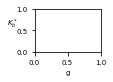

In [214]:
%matplotlib inline
Large_font_size = 12
Medium_font_size = 7
Small_font_size = 5
lw = 0.5
text_kwargs = dict(ha='center', va='center', color='C1')

#setting figuresize - by default matplotlib uses inches
#size of A4 sheet - 
cm_ = 1/2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(3*cm_, 2*cm_))
#ax.text(0.5, 1.5, f'Max font : {Large_font_size}pt', fontsize = Large_font_size, **text_kwargs)
#ax.text(0.5, 1.0, f'Med font : {Medium_font_size}pt', fontsize = Medium_font_size, **text_kwargs)
#ax.text(0.5, 0.5, f'Small font : {Small_font_size}pt', fontsize = Small_font_size, **text_kwargs)
ax.tick_params(axis='both', which='major', labelsize=Medium_font_size)
ax.set_ylabel(r"$K_b^*$", fontsize = Medium_font_size, rotation = 0)
ax.set_xlabel("g", fontsize = Medium_font_size)

os.makedirs("plots", exist_ok=True)

fig.savefig("plots/test.pdf", bbox_inches = "tight")

# Plot colorbars

In [215]:
N = 256
vals = np.ones((N, 4))
#orange - 255, 153, 51
vals[:, 0] = np.linspace(1,255/256,N) 
vals[:, 1] = np.linspace(1,153/256,N)
vals[:, 2] = np.linspace(1,51/256,N)
#to invert the color map, do np.linspace(255/256,1,N) and same for all the rest of the lines
cmap_isotropic = ListedColormap(vals)
#cmap_isotropic

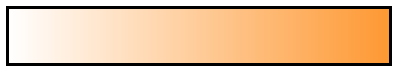

In [216]:

#fig,ax = plt.subplots()
fig = plt.figure(figsize = (15*cm_, 20*cm_))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
#cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', ticks=[], cmap='RdBu') #
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', ticks=[], cmap=cmap_isotropic) #
cb.outline.set_linewidth(3)
cb.set_alpha(1)
plt.savefig('plots/colorbar_isotropic.pdf', bbox_inches='tight')

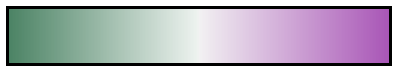

In [217]:
cmap_anisotropic = sns.diverging_palette(145,300, s=60, as_cmap=True)

#colorbar
fig = plt.figure(figsize = (15*cm_, 20*cm_))
ax = fig.add_axes([0.05, 0.80, 0.9, 0.1])
#cb = mpl.colorbar.ColorbarBase(ax, orientation='horizontal', ticks=[], cmap='RdBu') #
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', ticks=[], cmap=cmap_anisotropic) #
cb.outline.set_linewidth(3)
plt.savefig('plots/colorbar_anisotropic.pdf', bbox_inches='tight')

## Homogeneous isotropic surface 

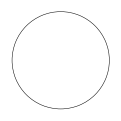

In [218]:
lambda_obj = np.poly1d([0,1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_isotropic,vmin = 1, vmax = 1.3)
fig.savefig("plots/inhomogeneous_isotropic_surface_no_gradient.pdf", bbox_inches = "tight")

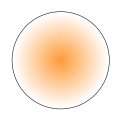

In [219]:
lambda_obj = np.poly1d([-0.5,1.5])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_isotropic, vmin = 1, vmax = 1.3)
fig.savefig("plots/inhomogeneous_isotropic_surface_gradient_in.pdf", bbox_inches = "tight")

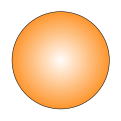

In [220]:
lambda_obj = np.poly1d([0.5,1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_isotropic, vmin = 1, vmax = 1.3)
fig.savefig("plots/inhomogeneous_isotropic_surface_gradient_out.pdf", bbox_inches = "tight")

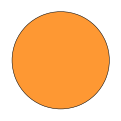

In [221]:
lambda_obj = np.poly1d([1.5])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)

ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_isotropic, vmin = 1, vmax = 1.3)
fig.savefig("plots/homogeneous_isotropic_surface.pdf", bbox_inches = "tight")

## Tangential elongation

In [253]:
quiver_scale=3
quiver_width=0.01
vmin = 0.7 
vmax = 1.3

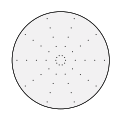

In [255]:
lambda_obj = np.poly1d([0, 1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width,
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/tangential_elongation_no_elongation.pdf", bbox_inches = "tight")

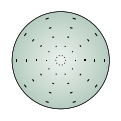

In [256]:
lambda_obj = np.poly1d([-0.1, 1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width,
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/tangential_elongation_gradient_out.pdf", bbox_inches = "tight")

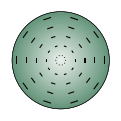

In [257]:
lambda_obj = np.poly1d([-0.25, 1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width,
                               )
cmap  = sns.diverging_palette(145, 300, s=60, as_cmap=True) #matplotlib.cm.PuOr
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/tangential_elongation_gradient_out_stronger.pdf", bbox_inches = "tight")

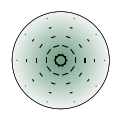

In [258]:
lambda_obj = np.poly1d([0.25, 0.75])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width,
                               )
cmap  = sns.diverging_palette(145, 300, s=60, as_cmap=True) #matplotlib.cm.PuOr
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/tangential_elongation_gradient_in_stronger.pdf", bbox_inches = "tight")

## Radial elongation

In [259]:
quiver_scale=8
quiver_width=0.01

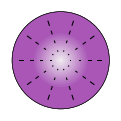

In [260]:
lambda_obj = np.poly1d([0.5, 1])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width, Rs = [0.2, 0.4, 0.6, 0.8]
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/radial_elongation_radially_increasing.pdf", bbox_inches = "tight")

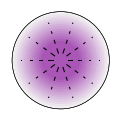

In [261]:
lambda_obj = np.poly1d([-0.5, 1.5])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width, Rs = [0.2, 0.4, 0.6, 0.8]
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/radial_elongation_radially_decreasing.pdf", bbox_inches = "tight")

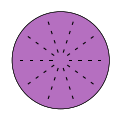

In [262]:
lambda_obj = np.poly1d([0, 1.25])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "outDV", thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width, Rs = [0.2, 0.4, 0.6, 0.8]
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/radial_elongation_radially_constant.pdf", bbox_inches = "tight")

## Inhomogeneous alongDV elongation

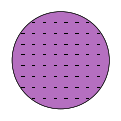

In [263]:
lambda_obj = np.poly1d([0, 1.25])
figsize = (8*cm_, 5*cm_)
fig,ax = plt.subplots(figsize = figsize)


thetas = np.arange(0,2*np.pi,2*np.pi/(10))
ax = get_nematic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, roi = "DV", #thetas = thetas,
                                quiver_scale = quiver_scale, quiver_width = quiver_width,
                               )
ax = get_isotropic_circle_subplot(ax, lambda_obj=lambda_obj, boundary_lw=lw, add_cbar=False, fontsize = Medium_font_size, cmap = cmap_anisotropic, vmin = vmin, vmax = vmax)
fig.savefig("plots/elongation_along_DV_constant.pdf", bbox_inches = "tight")